In [4]:
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import Pool
# from profilestats import profile
from scipy.stats import binned_statistic
from funcs.analysis import *
%matplotlib inline

# If nrows is left as none, then all rows will be read.
# Reduce this to 1,000 or 10,000 to read in a subset of the data.
nrows=None

def reader(n_subarray):
    return pd.read_csv('data/merged/{}/lc_{}.csv'.format(obj, n_subarray), nrows=nrows, index_col = ID, dtype = {'catalogue': np.uint8, 'mag_ps': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

In [5]:
obj = 'qsos'
ID  = 'uid'

# Here we load the analysis class. This has various attibutes and methods outlined in /funcs/analysis.py
# Examples:
# Photometry is in dr.df
# Grouped statistics is in dr.grouped
# DR12 VAC properties are in dr.properties
dr = analysis(obj, ID)

In [6]:
dr.read_in(reader, redshift=False)
# dr.group(keys = ['uid'],read_in=True)

In [7]:
dr.summary()

Number of qsos with lightcurves: 30
Number of datapoints in:
SDSS: 216
PS: 1,565
ZTF: 2,219


### Example: finding qsos given ra, dec

> Define a list of ra and decs in the format below

In [8]:
ra_dec = [[0.00531, -2.0332],[359.999615, 3.268586], [359.99851, -0.65588]]

In [9]:
found = dr.search(ra_dec, 1)
print(len(found))
found

3


,ra,dec,dist_arcsec
uid,,,
6,0.005317,-2.033273,0.265037
526347,359.998520,-0.655884,0.001054
526354,359.999615,3.268586,0.039144


### Load DR12 VAC catalogue

In [11]:
dr.load_vac()

In [12]:
dr.vac

,z,Mi,L5100,L5100_err,L3000,L3000_err,L1350,L1350_err,MBH_MgII,MBH_CIV,Lbol,Lbol_err,nEdd,sdss_name,ra,dec
uid,,,,,,,,,,,,,,,,
1,2.309,-23.883,-99.999,-9.999,-99.999,-9.999,45.120,0.111,-9.999,8.554,45.701,0.111,-0.953,000000.45+174625.4,0.001898,17.773739
3,2.498,-25.231,-99.999,-9.999,-99.999,-9.999,45.529,0.099,-9.999,9.018,46.110,0.099,-1.008,000000.66+145828.8,0.002756,14.974675
4,1.619,-25.600,-99.999,-9.999,45.544,0.067,45.666,0.134,8.529,-9.999,46.254,0.060,-0.375,000000.97+044947.2,0.004052,4.829781
6,1.360,-25.653,-99.999,-9.999,45.510,0.071,-99.999,-9.999,8.897,-9.999,46.222,0.071,-0.775,000001.27-020159.7,0.005317,-2.033273
7,2.328,-25.797,-99.999,-9.999,-99.999,-9.999,45.841,0.082,-9.999,8.670,46.422,0.082,-0.348,000001.37-011930.0,0.005746,-1.325009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526348,2.205,-26.896,-99.999,-9.999,45.948,0.133,46.139,0.092,9.121,9.568,46.701,0.076,-0.520,235959.70+084505.2,359.998774,8.751452
526350,2.416,-24.730,-99.999,-9.999,-99.999,-9.999,45.217,0.125,-9.999,8.287,45.798,0.125,-0.589,235959.74+100700.4,359.998922,10.116800
526352,2.451,-24.670,-99.999,-9.999,-99.999,-9.999,45.412,0.093,-9.999,8.713,45.993,0.093,-0.820,235959.78+285717.0,359.999118,28.954734


> Columns included in the value added catalogue:

In [13]:
def plot_series_bokeh(self, uids, survey=None):
    """
    Plot lightcurve of given objects using bokeh

    Parameters
    ----------
    uids : array_like
            uids of objects to plot
    catalogue : int
            Only plot data from given survey
    survey : 1 = SDSS, 2 = PS, 3 = ZTF

    """

    plots = []
    for uid in uids:
        single_obj = self.df.loc[uid]
        if survey is not None:
            single_obj = single_obj[single_obj['catalogue']==survey]
        p = figure(title='uid: {}'.format(uid), x_axis_label='mjd', y_axis_label='r mag', plot_width=1000, plot_height=400)
        for band in 'ugriz':
            single_band = single_obj[single_obj['filtercode']==band]
            for cat in single_band['catalogue'].unique():
                mjd, mag = single_band[single_band['catalogue']==cat][['mjd','mag']].sort_values('mjd').values.T
                p.scatter(x=mjd, y=mag, legend_label=self.survey_dict[cat], marker=self.marker_dict_bokeh[cat], color=self.plt_color_bokeh[band])
                p.line   (x=mjd, y=mag, line_width=0.5, color=self.plt_color_bokeh[band])
        p.y_range.flipped = True
        plots.append(p)

    show(column(plots))


In [14]:
output_notebook()

Loading BokehJS ...

> Example: plot photometry of quasars with uid: [6, 526352, 526344]
>> First using Bokeh

In [15]:
plot_series_bokeh(dr, [6, 200001, 420006])

>> Then using matplotlib (shows error bars)

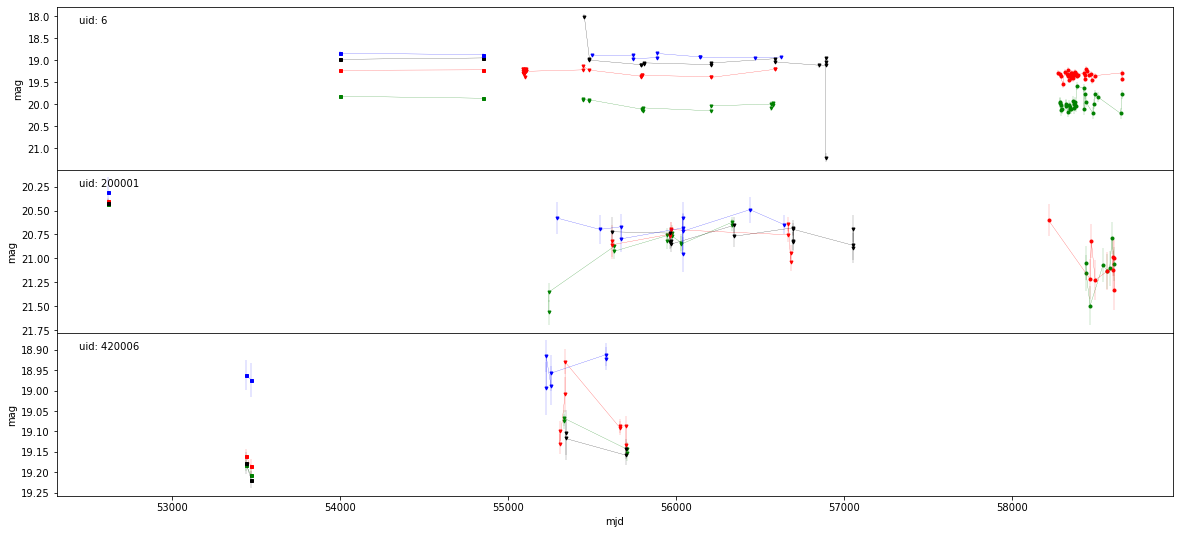

In [16]:
fig, ax = dr.plot_series([6, 200001, 420006])